# Import Libraries

In [1]:
! pip install geemap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 55.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 80.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 64.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.7/224.7 KB 24.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.6/99.6 KB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 KB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 KB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 KB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 69.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━

In [2]:
!pip -q install --upgrade folium
!apt install libspatialindex-dev
!pip -q install rtree
!pip -q install geopandas
!pip -q install geojson
!pip -q install geemap
!pip -q uninstall tornado -y
!yes | pip install tornado==5.1.0
!pip -q install rasterio
!pip -q install tqdm
!pip -q install eeconvert

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.3/102.3 KB 7.8 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libspatialindex-c6 libspatialindex6
The following NEW packages will be installed:
  libspatialindex-c6 libspatialindex-dev libspatialindex6
0 upgraded, 3 newly installed, 0 to remove and 23 not upgraded.
Need to get 340 kB of archives.
After this operation, 1,538 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 libspatialindex6 amd64 1.9.3-1build1 [266 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 libspatialindex-c6 amd64 1.9.3-1build1 [58.3 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 libspatialindex-dev amd64 1.9.3-1build1 [16.0 kB]
Fetched 340 kB in 1s (484 kB/s)
Selecting previously unselected package libspatialindex6:amd64.
(Reading database ... 128276 files and di

In [3]:
# Standard imports
from tqdm.notebook import tqdm
import requests
import json

import pandas as pd
import numpy as np
from PIL import Image

# Geospatial processing packages
import geopandas as gpd
import geojson

import shapely 
import rasterio as rio
from rasterio.plot import show
import rasterio.mask
from shapely.geometry import box

# Mapping and plotting libraries
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import ee
import eeconvert as eec
import geemap
import geemap.foliumap as emap
import folium

# # Deep learning libraries
# import torch
# from torchvision import datasets, models, transforms

In [4]:
# import modules
import time
import os
import ee 
import geemap

# Dowload Data

In [5]:
# Trigger the authentication flow.
ee.Authenticate()


To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=l5bA7t14rZHmdiK8m3kmPSK_THTp5a4XcNgt1QjxbKY&tc=yTp9zjzfoYMeyGmib2O73I6J9PPdpesYrfXXqP5LYuY&cc=8GF-UkcigsPnSqS1_ybrTjlFnuqjGUnwLeRMlHn9VPw

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AWtgzh4VHnyYfEW6oipwR1N80-cPAzYwKK6hamBxAiXoIzWUG4jL7XXwLHw

Successfully saved authorization token.


In [6]:
# Initialize the library.
ee.Initialize()

## On Cameroon

In [7]:
# # get our Cameroon boundary
aoi = ee.FeatureCollection("FAO/GAUL/2015/level0").filter(ee.Filter.eq('ADM0_NAME','Cameroon')).geometry()


In [167]:
# Function to mask clouds using the Sentinel-2 QA band

def se2mask(image):
    quality_band = image.select('QA60')
    
    # using the bit mask for clouds and cirrus clouds respectively
    cloudmask = 1 << 10
    cirrusmask = 1 << 11
    
    # we only want clear skies
    mask = quality_band.bitwiseAnd(cloudmask).eq(0) and (quality_band.bitwiseAnd(cirrusmask).eq(0))
    
    # we'll divide by 10000 to make interpreting the reflectance values easier
    return image.updateMask(mask).divide(10000)
    
se2 = ee.ImageCollection('COPERNICUS/S2').filterDate(
    "2019-01-01","2019-12-31").filterBounds(aoi).filter(
    ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE",20)).map(se2mask).median()



In [170]:
# initialize our map
map2 = geemap.Map()
map2.centerObject(aoi, 7)
rgb = ['B4','B3','B2']

# set some thresholds
rgbViz = {"min":0.0, "max":0.3,"bands":rgb}
map2.addLayer(se2.clip(aoi), rgbViz, "S2")

map2.addLayerControl()
map2

Map(center=[5.68207224940031, 12.739010886474453], controls=(WidgetControl(options=['position', 'transparent_b…

In [ ]:
geemap.ee_export_image(se2.clip(aoi).select(["B5","B4","B3","B2"]), filename='/content/drive/MyDrive/Colab Notebooks/LandCover/se2_2019.tif',  region=aoi)

Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/Colab Notebooks/LandCover/se2_2019.tif


In [61]:
land_8 = ee.ImageCollection("LANDSAT/LC08/C01/T1_RT_TOA").filterDate("2019-01-01","2019-12-31").filterMetadata("CLOUD_COVER","less_than",20).select(["B5","B4","B3","B2"]).median()

In [ ]:
geemap.ee_export_image(land_8.clip(aoi), filename='/content/drive/MyDrive/Colab Notebooks/LandCover/land_8_2019.tif',  region=aoi)

Generating URL ...
Please wait ...
Data downloaded to /content/drive/MyDrive/Colab Notebooks/LandCover/land_8_2019.tif


In [137]:
def export_image(image, filename, region, folder):
    """Export Image to Google Drive.
    
    Args:
      image (ee.image.Image): Generated Sentinel-2 image
      filename (str): Name of image, without the file extension
      geometry (ee.geometry.Geometry): The geometry of the area of 
        interest to filter to.
      folder (str): The destination folder in your Google Drive.

    Returns:
      ee.batch.Task: A task instance
    """

    print('Exporting to {}.tif ...'.format(filename))
        
    task = ee.batch.Export.image.toDrive(
      image=image,
      driveFolder=folder,
      scale=10,
      region=region,
      description=filename,
      fileFormat='GeoTIFF',
      crs='EPSG:4326',
      maxPixels=10892593149
    )
    task.start()
    
    return task

In [148]:
folder = 'Colab Notebooks' # Change this to your file destination folder in Google drive
task = export_image(land_8.clip(aoi), 'land_8_trial_2', aoi, '/content/drive/MyDrive/Colab Notebooks/LandCover/')

Exporting to land_8_trial_3.tif ...


In [157]:
task.status()

{'state': 'FAILED',
 'description': 'land_8_trial_3',
 'creation_timestamp_ms': 1679161571921,
 'update_timestamp_ms': 1679161584778,
 'start_timestamp_ms': 1679161583150,
 'task_type': 'EXPORT_IMAGE',
 'attempt': 1,
 'error_message': 'Image.visualize: Cannot provide a palette when visualizing more than one band.',
 'id': 'EGKTTWZCDQEFM2KZEK2UOU6Y',
 'name': 'projects/earthengine-legacy/operations/EGKTTWZCDQEFM2KZEK2UOU6Y'}

## Lancover labels

In [ ]:
def export_image(image, filename, region, folder):
    """Export Image to Google Drive.
    
    Args:
      image (ee.image.Image): Generated Sentinel-2 image
      filename (str): Name of image, without the file extension
      geometry (ee.geometry.Geometry): The geometry of the area of 
        interest to filter to.
      folder (str): The destination folder in your Google Drive.

    Returns:
      ee.batch.Task: A task instance
    """

    print('Exporting to {}.tif ...'.format(filename))

  
        
    task = ee.batch.Export.image.toDrive(
      image=image.visualize( **{  "min": 1.0, "max": 17.0,
  'palette': [
    '05450a', '086a10', '54a708', '78d203', '009900', 'c6b044', 'dcd159',
    'dade48', 'fbff13', 'b6ff05', '27ff87', 'c24f44', 'a5a5a5', 'ff6d4c',
    '69fff8', 'f9ffa4', '1c0dff']}),
      driveFolder=folder,
      scale=10,
      region=region,
      description=filename,
      fileFormat='GeoTIFF',
      crs='EPSG:4326',
      maxPixels=10892593149
    )
    task.start()
    
    return task

In [165]:
block  = ee.FeatureCollection("FAO/GAUL/2015/level0").filter(ee.Filter.eq('ADM0_NAME','Cameroon')).geometry()

dataset = ee.ImageCollection('MODIS/006/MCD12Q1').select('LC_Type1').filterDate('2018-01-01','2018-05-01');

Map = geemap.Map()
landcover = dataset.mean();
block_landcover = landcover.clip(block);
scale = block_landcover.projection().nominalScale();

# print ("MODIS Scale", scale)

# Value	Color	Description
# 0	1c0dff	Water
# 1	05450a	Evergreen needleleaf forest
# 2	086a10	Evergreen broadleaf forest
# 3	54a708	Deciduous needleleaf forest
# 4	78d203	Deciduous broadleaf forest
# 5	009900	Mixed forest
# 6	c6b044	Closed shrublands
# 7	dcd159	Open shrublands
# 8	dade48	Woody savannas
# 9	fbff13	Savannas
# 10	b6ff05	Grasslands
# 11	27ff87	Permanent wetlands
# 12	c24f44	Croplands
# 13	a5a5a5	Urban and built-up
# 14	ff6d4c	Cropland/natural vegetation mosaic
# 15	69fff8	Snow and ice
# 16	f9ffa4	Barren or sparsely vegetated
# 254	ffffff	Unclassified

# https://developers.google.com/earth-engine/datasets/catalog/MODIS_061_MCD12Q1
# ['Evergreen Needleleaf Forests', 'Evergreen Broadleaf Forests', 
#   'Deciduous Needleleaf Forests', 'Deciduous Broadleaf Forests', 
#   'Mixed Forests', 'Closed Shrublands', 'Open Shrublands', 'Woody Savannas',
#   'Savannas', 'Grasslands', 'Permanent Wetlands', 'Croplands', 'Urban and Built-up Lands', 
#   'Cropland, Natural Vegetation, Mosaic', 'Permanent Snow and Ice', 'Barren', 'Water Bodies']
Vis = { "min": 1.0, "max": 17.0,
  "palette": [
    '05450a', '086a10', '54a708', '78d203', '009900', 'c6b044', 'dcd159',
    'dade48', 'fbff13', 'b6ff05', '27ff87', 'c24f44', 'a5a5a5', 'ff6d4c',
    '69fff8', 'f9ffa4', '1c0dff']};

Map.centerObject(block_landcover, 8);
Map.addLayer(block_landcover, Vis, 'Land cover');

In [166]:
Map

Map(center=[5.68207224940031, 12.739010886474453], controls=(WidgetControl(options=['position', 'transparent_b…

In [ ]:
folder = 'Colab Notebooks' # Change this to your file destination folder in Google drive
task = export_image(dataset.clip(aoi).mean(), 'land_8_label', aoi, '/content/drive/MyDrive/Colab Notebooks/LandCover/')

## Visualize store tiff files

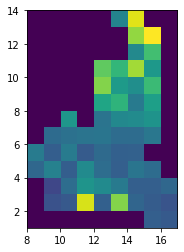

<Axes: >

In [21]:
import rasterio
from rasterio.plot import show
fp = r'/content/drive/MyDrive/Colab Notebooks/LandCover/se2_2019.tif'
img = rasterio.open(fp)
show(img)

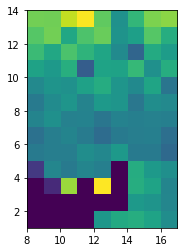

<Axes: >

In [ ]:
import rasterio
from rasterio.plot import show
fp = r'/content/drive/MyDrive/Colab Notebooks/LandCover/land_8_2019.tif'
img = rasterio.open(fp)
show(img)

In [ ]:
js_snippet = """
// Load an image.
var image = ee.Image('LANDSAT/LC08/C01/T1_TOA/LC08_044034_20140318');

// Define the visualization parameters.
var vizParams = {
  bands: ['B5', 'B4', 'B3'],
  min: 0,
  max: 0.5,
  gamma: [0.95, 1.1, 1]
};

// Center the map and display the image.
Map.setCenter(-122.1899, 37.5010, 10); // San Francisco Bay
Map.addLayer(image, vizParams, 'false color composite');

"""

In [ ]:
js_snippet = """
var block  = ee.FeatureCollection("FAO/GAUL/2015/level0").filter(ee.Filter.eq('ADM0_NAME','Cameroon')).geometry()

var dataset = ee.ImageCollection('MODIS/006/MCD12Q1')
  .select('LC_Type1')
  .filterDate('2018-01-01','2018-05-01');

var landcover = dataset.first();
var block_landcover = landcover.clip(block);
var scale = block_landcover.projection().nominalScale();

print ("MODIS Scale", scale);


var Vis = { min: 1.0, max: 17.0,
  palette: [
    '05450a', '086a10', '54a708', '78d203', '009900', 'c6b044', 'dcd159',
    'dade48', 'fbff13', 'b6ff05', '27ff87', 'c24f44', 'a5a5a5', 'ff6d4c',
    '69fff8', 'f9ffa4', '1c0dff']};

Map.centerObject(block_landcover, 8);
Map.addLayer(block_landcover, Vis, 'Land cover');

var classes_list = ['Evergreen Needleleaf Forests', 'Evergreen Broadleaf Forests', 
  'Deciduous Needleleaf Forests', 'Deciduous Broadleaf Forests', 
  'Mixed Forests', 'Closed Shrublands', 'Open Shrublands', 'Woody Savannas',
  'Savannas', 'Grasslands', 'Permanent Wetlands', 'Croplands', 'Urban and Built-up Lands', 
  'Cropland, Natural Vegetation, Mosaic', 'Permanent Snow and Ice', 'Barren', 'Water Bodies'];

var list = ee.List.sequence(1, 17, 1);

var areas = list.map(function(l){

    var iter = ee.Number(l).int();

    var areas_list = ee.List([]);

    var areas = block_landcover
     .eq(iter)
     .multiply(ee.Image.pixelArea().divide(10000))
     .reduceRegion({
        reducer: ee.Reducer.sum(),
        geometry: block,  // a geometry
        scale: 463.3127165275,   // scale for MODIS
        maxPixels: 1e9  
    });

    areas_list = areas_list.add(areas.values()).get(0);

    return areas_list;

}).flatten();

var fus_list2 = ee.List(classes_list).zip(areas);

print(fus_list2);

"""

In [ ]:
lines = geemap.js_snippet_to_py(js_snippet, add_new_cell=False, import_ee=True, import_geemap=True, show_map=True)
for line in lines:
    print(line.rstrip())

import ee
import geemap
Map = geemap.Map()

block  = ee.FeatureCollection("FAO/GAUL/2015/level0").filter(ee.Filter.eq('ADM0_NAME','Cameroon')).geometry()

dataset = ee.ImageCollection('MODIS/006/MCD12Q1') \
  .select('LC_Type1') \
  .filterDate('2018-01-01','2018-05-01')

landcover = dataset.first()
block_landcover = landcover.clip(block)
scale = block_landcover.projection().nominalScale()

print ("MODIS Scale", scale)

Vis = { 'min': 1.0, 'max': 17.0,
  'palette': [
    '05450a', '086a10', '54a708', '78d203', '009900', 'c6b044', 'dcd159',
    'dade48', 'fbff13', 'b6ff05', '27ff87', 'c24f44', 'a5a5a5', 'ff6d4c',
    '69fff8', 'f9ffa4', '1c0dff']}

Map.centerObject(block_landcover, 8)
Map.addLayer(block_landcover, Vis, 'Land cover')

classes_list = ['Evergreen Needleleaf Forests', 'Evergreen Broadleaf Forests',
  'Deciduous Needleleaf Forests', 'Deciduous Broadleaf Forests',
  'Mixed Forests', 'Closed Shrublands', 'Open Shrublands', 'Woody Savannas',
  'Savannas', 'Grasslands', 'Permane

In [ ]:
# import ee
# import geemap
# Map = geemap.Map()

# block  = ee.FeatureCollection("FAO/GAUL/2015/level0").filter(ee.Filter.eq('ADM0_NAME','Cameroon')).geometry()

# se2 = ee.ImageCollection('COPERNICUS/S2').filterDate(
#     "2019-01-01","2019-12-31").filterBounds(block).filter(
#     ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE",20)).map(se2mask).median()

# landcover = se2
# block_landcover = landcover.clip(block)
# scale = block_landcover.projection().nominalScale()

# # print ("MODIS Scale", scale)

# Vis = { 'min': 1.0, 'max': 17.0,
#   'palette': [
#     '05450a', '086a10', '54a708', '78d203', '009900', 'c6b044', 'dcd159',
#     'dade48', 'fbff13', 'b6ff05', '27ff87', 'c24f44', 'a5a5a5', 'ff6d4c',
#     '69fff8', 'f9ffa4', '1c0dff']}

# Map.centerObject(block_landcover, 8)
# Map.addLayer(block_landcover, Vis, 'Land cover')

# # classes_list = ['Evergreen Needleleaf Forests', 'Evergreen Broadleaf Forests',
# #   'Deciduous Needleleaf Forests', 'Deciduous Broadleaf Forests',
# #   'Mixed Forests', 'Closed Shrublands', 'Open Shrublands', 'Woody Savannas',
# #   'Savannas', 'Grasslands', 'Permanent Wetlands', 'Croplands', 'Urban and Built-up Lands',
# #   'Cropland, Natural Vegetation, Mosaic', 'Permanent Snow and Ice', 'Barren', 'Water Bodies']

# # list = ee.List.sequence(1, 17, 1)

# # def func_jde(l):

# #     iter = ee.Number(l).int()

# #     areas_list = ee.List([])

# #     areas = block_landcover \
# #      .eq(iter) \
# #      .multiply(ee.Image.pixelArea().divide(10000)) \
# #      .reduceRegion({
# #         'reducer': ee.Reducer.sum(),
# #         'geometry': block,  # a geometry
# #         'scale': 463.3127165275,   # scale for MODIS
# #         'maxPixels': 1e9
# #     })

# #     areas_list = areas_list.add(areas.values()).get(0)

# #     return areas_list

# # areas = list.map(func_jde.flatten()).flatten()

# # fus_list2 = ee.List(classes_list).zip(areas)

# # print(fus_list2)

# Map

EEException: ignored

In [ ]:
# import ipyleaflet
# map2 =geemap.Map()

# Vis = { 'min': 1.0, 'max': 17.0,
#   'palette': [
#     '05450a', '086a10', '54a708', '78d203', '009900', 'c6b044', 'dcd159',
#     'dade48', 'fbff13', 'b6ff05', '27ff87', 'c24f44', 'a5a5a5', 'ff6d4c',
#     '69fff8', 'f9ffa4', '1c0dff']}

# map2.centerObject(aoi, 8)
# map2.addLayer(se2.clip(aoi), Vis, 'Land cover')

# map2.addLayerControl()
# map2


In [ ]:
# classes_list = ['Evergreen Needleleaf Forests', 'Evergreen Broadleaf Forests', 
#   'Deciduous Needleleaf Forests', 'Deciduous Broadleaf Forests', 
#   'Mixed Forests', 'Closed Shrublands', 'Open Shrublands', 'Woody Savannas',
#   'Savannas', 'Grasslands', 'Permanent Wetlands', 'Croplands', 'Urban and Built-up Lands', 
#   'Cropland, Natural Vegetation, Mosaic', 'Permanent Snow and Ice', 'Barren', 'Water Bodies'];

# # var list = ee.List.sequence(1, 17, 1);

# # var areas = list.map(function(l){

# #     var iter = ee.Number(l).int();

# #     var areas_list = ee.List([]);

# #     var areas = block_landcover
# #      .eq(iter)
# #      .multiply(ee.Image.pixelArea().divide(10000))
# #      .reduceRegion({
# #         reducer: ee.Reducer.sum(),
# #         geometry: block,  // a geometry
# #         scale: 463.3127165275,   // scale for MODIS
# #         maxPixels: 1e9  
# #     });

# #     areas_list = areas_list.add(areas.values()).get(0);

# #     return areas_list;

Map(center=[5.68207224940031, 12.739010886474453], controls=(WidgetControl(options=['position', 'transparent_b…